# DSW Export for PanAn 01

Come back to and fix once all files loaded.

In [2]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import gsw
from pathlib import Path

import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.path as mpath

import netCDF4 as nc
import xarray as xr
import numpy as np
import xgcm
import calendar

from matplotlib import gridspec
from collections import OrderedDict

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [3]:
import logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

In [4]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37491/status,
Dashboard: /proxy/37491/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44971,Workers: 0
Dashboard: /proxy/37491/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35811,Total threads: 1
Dashboard: /proxy/39157/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:39801,


### Importing the data

In [5]:
# Importing data
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-01-zstar-ssp126-MW-only/*/*.ocean_month_z.nc'))

In [6]:
# Contour mask
isobath_depth = 1000
outfile = '/g/data/ik11/grids'+'/Antarctic_slope_contour_'+str(isobath_depth)+'m_MOM6_01deg.nc'
contour_mask = xr.open_dataset(outfile)

In [7]:
contour_mask

<xarray.Dataset> Size: 38MB
Dimensions:                    (yh: 533, xq: 3600, yq: 533, xh: 3600)
Coordinates:
  * yh                         (yh) float64 4kB -79.0 -78.95 ... -55.12 -55.07
  * xq                         (xq) float64 29kB -279.9 -279.8 ... 79.9 80.0
  * yq                         (yq) float64 4kB -78.98 -78.93 ... -55.1 -55.04
  * xh                         (xh) float64 29kB -279.9 -279.8 ... 79.85 79.95
Data variables:
    mask_x_transport           (yh, xq) float32 8MB ...
    mask_y_transport           (yq, xh) float32 8MB ...
    mask_x_transport_numbered  (yh, xq) float32 8MB ...
    mask_y_transport_numbered  (yq, xh) float32 8MB ...
    contour_masked_above       (yh, xh) float32 8MB ...

In [8]:
# had to change this bc of contour files
lat_slice = slice(-79,-59)

In [9]:
# Time variant variables
def preprocess(ds):
    ds = ds[['uo','vo','agessc','so']] # Picking out variables get all grids
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [10]:
# Load grid variables
yh = cont['yh'].sel(yh=lat_slice)
yq = cont['yq'].sel(yq=lat_slice)
xh = cont['xh']
xq = cont['xq']
deptho = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho'].sel(yh=lat_slice)

In [11]:
path_to_ocean_static = Path('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output021/20000701.ocean_static.nc')
ocean_static = xr.open_dataset(path_to_ocean_static)

In [12]:
ocean_static = ocean_static.sel(xq = cont['xq'], xh = cont['xh'], yq = cont['yq'].sel(yq=lat_slice), yh = cont['yh'].sel(yh=lat_slice))

grid = xgcm.Grid(ocean_static, coords = {'X': {'center': 'xh', 'right': 'xq'},
                                     'Y': {'center': 'yh', 'right': 'yq'}},
                                   periodic = ['X'])

In [13]:
mask_y_transport = contour_mask['mask_y_transport'].sel(yq=lat_slice)
mask_x_transport = contour_mask['mask_x_transport'].sel(yh=lat_slice)
mask_y_transport_numbered = contour_mask['mask_y_transport_numbered'].sel(yq=lat_slice)
mask_x_transport_numbered = contour_mask['mask_x_transport_numbered'].sel(yh=lat_slice)

### Some test plots

In [46]:
y_on_center = mask_y_transport.sel(yq=slice(-79,-59)).interp(yq=mask_x_transport['yh'])
y_on_center = y_on_center.rename({'yq': 'yh'})  # rename to match final grid

ValueError: the new name 'yh' conflicts

In [47]:
x_on_center = mask_x_transport.sel(yh=slice(-79,-59)).interp(xq=mask_y_transport['xh'])
x_on_center = x_on_center.rename({'xq': 'xh'})  # rename to match final grid

ValueError: the new name 'xh' conflicts

Text(0.5, 1.0, '1000m isobath contour PanAn01')

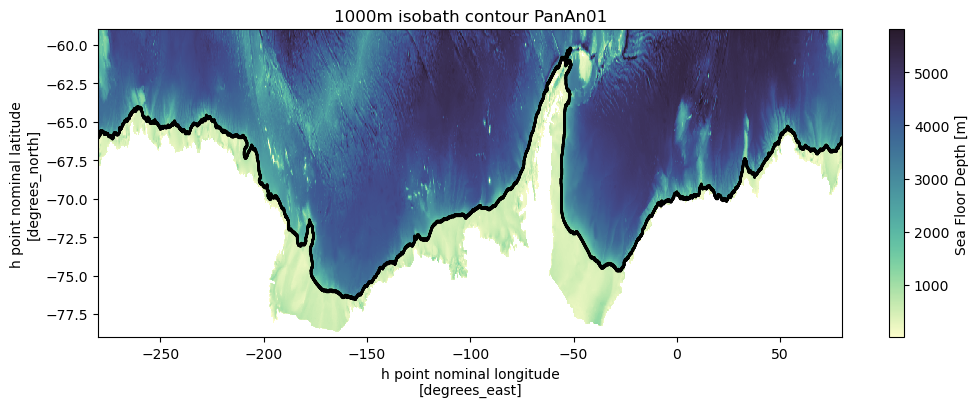

In [48]:
# Plot contour
fig, axes = plt.subplots(figsize = (12,4))
deptho.plot(ax = axes, cmap = cm.cm.deep)
axes.contour(xh.values, yh.values,np.abs(x_on_center)+np.abs(y_on_center),colors = 'k')
axes.set_title('1000m isobath contour PanAn01')

In [49]:
# now plot age anomaly instead

# select out bottom values:
start_time = '2001-01-01'
end_time = '2010-12-31'
time_slice = slice(start_time,end_time)

cont = cont.sel(time = time_slice,yh=lat_slice)
melt = melt.sel(time = time_slice,yh=lat_slice)

age_con = cont['agessc'].sel(time = time_slice,yh=lat_slice)
age_melt = melt['agessc'].sel(time = time_slice,yh=lat_slice)

day_in_month = age_melt.time.dt.days_in_month
age_con_mean = (age_con*day_in_month).sum('time')/day_in_month.sum('time')
age_melt_mean = (age_melt*day_in_month).sum('time')/day_in_month.sum('time')

In [50]:
age_con_mean

<xarray.DataArray (z_l: 75, yh: 460, xh: 3600)> Size: 994MB
dask.array<truediv, shape=(75, 460, 3600), dtype=float64, chunksize=(22, 242, 1030), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 4kB -79.0 -78.95 -78.91 ... -59.14 -59.08 -59.03
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [51]:
age_con_mean = age_con_mean.load()

2025-08-04 00:53:50,399 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:38671 -> tcp://127.0.0.1:37659
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/tornado/iostream.py", line 1113, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/distributed/worker.py", line 1795, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^

In [ ]:
age_melt_mean = age_melt_mean.load()

In [ ]:
depth_array = age_con.isel(time =0) * 0 + age_con.z_l
max_depth = depth_array.max(dim = 'z_l', skipna= True)

bottom_age_con = age_con_mean.where(depth_array.z_l >= max_depth)
bottom_age_con = bottom_age_con.sum(dim = 'z_l')
bottom_age_con = bottom_age_con.load()

bottom_age_melt = age_melt_mean.where(depth_array.z_l >= max_depth)
bottom_age_melt = bottom_age_melt.sum(dim = 'z_l')
bottom_age_melt = bottom_age_melt.load()

In [ ]:
land_mask = np.squeeze(deptho.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

# make land go all the way to -90S:
land_mask_lat = deptho.yh.values
land_mask_lat[0] = -90

In [ ]:
fig, axes = plt.subplots(figsize = (12,4))
(bottom_age_melt-bottom_age_con).plot(ax = axes, cmap = cm.cm.balance, cbar_kwargs = {'label':'Age anomaly (yrs)'}, vmax = 1, vmin = -1)
axes.contour(xh.values, yh.values,np.abs(mask_x_transport)+np.abs(mask_y_transport),colors = 'k')
axes.contourf(deptho.xh, land_mask_lat,land_mask_masked,colors='dimgrey',zorder=2,)
axes.set_title('1000m isobath contour - Meltwater -- Control')

### Make nicer y axis than `contour_index` by loading in lon/lat/distance of contour

Need to fix this up to be for PanAn grid.

In [22]:
## Doing my own interp?

#mask_y_transport = grid.interp(mask_y_transport, 'Y')
#mask_x_transport = grid.interp(mask_x_transport, 'X')
#mask_x_transport

In [14]:
mask_x_transport = xr.DataArray(mask_x_transport, coords = [yh, xq[:-1]], dims=['y_ocean', 'x_ocean'])
mask_y_transport = xr.DataArray(mask_y_transport, coords = [yq, xh], dims=['y_ocean', 'x_ocean'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [yh, xq[:-1]], dims=['y_ocean', 'x_ocean'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [yq, xh], dims=['y_ocean', 'x_ocean'])

In [15]:
# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1,len(contour_ordering)+1)

In [16]:
# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.y_ocean
lon_along_contour = contour_ordering.x_ocean
# don't need the multi-index anymore, replace with contour count
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array

In [17]:
dxu = ocean_static['dxCu']
dxu

<xarray.DataArray 'dxCu' (yh: 460, xq: 3601)> Size: 7MB
[1656460 values with dtype=float32]
Coordinates:
  * yh       (yh) float64 4kB -79.0 -78.95 -78.91 ... -59.14 -59.08 -59.03
  * xq       (xq) float64 29kB -280.0 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
Attributes:
    units:          m
    long_name:      Delta(x) at u points (meter)
    cell_methods:   time: point
    interp_method:  none

In [32]:
 ## Save distance - this takes time so instead load result in next cell

# Load MOM6 grid variables
dxCu = ocean_static['dxCu']
dxCu = dxCu.sel(yh=lat_slice)

dyCv =  ocean_static['dyCv']
dyCv = dyCv.sel(yq=lat_slice)

lat_t = ocean_static['geolat']
lat_t = lat_t.sel(yh=lat_slice)

lon_t = ocean_static['geolon']
lon_t = lon_t.sel(yh=lat_slice)

# if there is a bend in the contour, add the distance using length of diagonal, not sum of
# 2 edges, to be more representative.    
# Preallocate array
num_points = len(lat_along_contour)
distance_along_contour = np.zeros(num_points)

# Indices along the contour
x_indices = np.sort(mask_x_transport_numbered.values[mask_x_transport_numbered.values > 0])
y_indices = np.sort(mask_y_transport_numbered.values[mask_y_transport_numbered.values > 0])

skip = False
for count in range(1, num_points):
    if skip:
        skip = False
        continue

    if count in y_indices:
        if count + 1 in y_indices:
            jj, ii = np.where(mask_y_transport_numbered == count)
            distance_along_contour[count - 1] = float(dxCu.isel(yh=jj[0], xq=ii[0]))
        else:
            jj0, ii0 = np.where(mask_y_transport_numbered == count)
            jj1, ii1 = np.where(mask_x_transport_numbered == count + 1)
            dx_val = float(dxCu.isel(yh=jj0[0], xq=ii0[0]))
            dy_val = float(dyCv.isel(yq=jj1[0], xh=ii1[0]))
            diag = 0.5 * np.sqrt(dx_val ** 2 + dy_val ** 2)
            distance_along_contour[count - 1] = diag
            distance_along_contour[count] = diag
            skip = True

    elif count in x_indices:
        if count + 1 in x_indices:
            jj, ii = np.where(mask_x_transport_numbered == count)
            distance_along_contour[count - 1] = float(dyCv.isel(yq=jj[0], xh=ii[0]))
        else:
            jj0, ii0 = np.where(mask_x_transport_numbered == count)
            jj1, ii1 = np.where(mask_y_transport_numbered == count + 1)
            dy_val = float(dyCv.isel(yq=jj0[0], xh=ii0[0]))
            dx_val = float(dxCu.isel(yh=jj1[0], xq=ii1[0]))
            diag = 0.5 * np.sqrt(dy_val ** 2 + dx_val ** 2)
            distance_along_contour[count - 1] = diag
            distance_along_contour[count] = diag
            skip = True

# Final point fix
if distance_along_contour[-1] == 0:
    count += 1
    if count in y_indices:
        jj, ii = np.where(mask_y_transport_numbered == count)
        distance_along_contour[-1] = float(dxCu.isel(yh=jj[0], xq=ii[0]))
    else:
        jj, ii = np.where(mask_x_transport_numbered == count)
        distance_along_contour[-1] = float(dyCv.isel(yq=jj[0], xh=ii[0]))

# Convert to 1000 km units
distance_along_contour = np.cumsum(distance_along_contour) / 1e6  # meters → 1000 km

# Save
save_dir = '/g/data/x77/kc5856/Post_Process/panan-01/'
ds_latlondist = xr.Dataset({'distance_along_contour': distance_along_contour})
ds_latlondist.to_netcdf(save_dir+'1000m_isobath_contour_distance.nc')

In [18]:
# If already loaded, just use:
distance_along_contour = xr.open_dataset('/g/data/x77/kc5856/Post_Process/panan-01/1000m_isobath_contour_distance.nc').distance_along_contour

In [19]:
distance_along_contour

<xarray.DataArray 'distance_along_contour' (distance_along_contour: 6052)> Size: 48kB
array([3.255779e-03, 6.511559e-03, 1.102909e-02, ..., 2.101659e+01,
       2.101984e+01, 2.102436e+01])
Coordinates:
  * distance_along_contour  (distance_along_contour) float64 48kB 0.003256 .....

In [20]:
#determine where to put lon tick marks
distance_indices = np.zeros(8)
for i in np.arange(100,len(lon_along_contour.values)):
    if (distance_indices[1]==0):
        if (lon_along_contour.values[i]>-240):
            distance_indices[1] = lon_along_contour.contour_index.values[i]
    if (distance_indices[2]==0):
        if (lon_along_contour.values[i]>-180):
            distance_indices[2] = lon_along_contour.contour_index.values[i]
    if (distance_indices[3]==0):
        if (lon_along_contour.values[i]>-120):
            distance_indices[3] = lon_along_contour.contour_index.values[i]
    if (distance_indices[4]==0):
        if lon_along_contour.values[i]>-60:
            distance_indices[4] = lon_along_contour.contour_index.values[i]
    if (distance_indices[5]==0):
        if (lon_along_contour.values[i]>0):
            distance_indices[5] = lon_along_contour.contour_index.values[i]
    if (distance_indices[6]==0):
        if (lon_along_contour.values[i]>60):
            distance_indices[6] = lon_along_contour.contour_index.values[i]
distance_indices[7] = len(lon_along_contour.contour_index.values)-1

### Looking at my data

In [21]:
# Importing data
path_cont_transport = np.sort(glob.glob('/g/data/x77/kc5856/sofia-cross_slope_transport/panant-01-zstar-ACCESSyr2/Antarctic_cross_slope/vol_transp_across_1000m_isobath_*.nc'))
path_melt_transport = np.sort(glob.glob('/g/data/x77/kc5856/sofia-cross_slope_transport/panant-01-zstar-ssp126-MW-only/Antarctic_cross_slope/vol_transp_across_1000m_isobath_*.nc'))

### Save transport individual files together (time mean)
This section saves data as netcdfs to improve loading speed.

(SKIP THIS SECTION IF ALREADY COMPLETE)

In [22]:
#get time data
salt = cont['so']
salt = salt.sel(time = slice('2001-01-01','2010-12-31'))
time_data = salt.time

In [54]:
def load_yearly_data(name,expt_id):
    """
    Load yearly transport data across 1000m isobath from 2001 to 2010 inclusive.

    Parameters:
    name (str): Subdirectory name for the experiment.

    Returns:
    xr.DataArray: Combined transport across contour for all years.
    int: Total number of days summed across files.
    """
    base_path = f'/g/data/x77/kc5856/sofia-cross_slope_transport/{name}/Antarctic_cross_slope/'
    start_year = 2001
    end_year = 2010  # inclusive

    all_data = []
    total_days = 0

    for year in range(start_year, end_year + 1):  # Note the +1 to include 2010
        filepath = f'{base_path}vol_transp_across_1000m_isobath_{expt_id}_1m_{year}.nc'
        ds = xr.open_dataset(filepath)
        all_data.append(ds.vol_trans_across_contour)
        days_in_year = 366 if calendar.isleap(year) else 365
        total_days += days_in_year
        print(f"Loaded {year}, days counted: {days_in_year}")

    combined = xr.concat(all_data, dim='time')
    return combined, total_days

In [23]:
control_name = 'panant-01-zstar-ACCESSyr2' 
melt_name = 'panant-01-zstar-ssp126-MW-only' # change for new melt run!
control_id = 'panan_01deg_cont'
melt_id = 'panan_01deg_melt'

In [58]:
control_vol_trans, ndays = load_yearly_data(control_name,control_id)
print(ndays)
melt_vol_trans, ndays = load_yearly_data(melt_name,melt_id)
print(ndays)

Loaded 2001, days counted: 365
Loaded 2002, days counted: 365
Loaded 2003, days counted: 365
Loaded 2004, days counted: 366
Loaded 2005, days counted: 365
Loaded 2006, days counted: 365
Loaded 2007, days counted: 365
Loaded 2008, days counted: 366
Loaded 2009, days counted: 365
Loaded 2010, days counted: 365
3652
Loaded 2001, days counted: 365
Loaded 2002, days counted: 365
Loaded 2003, days counted: 365
Loaded 2004, days counted: 366
Loaded 2005, days counted: 365
Loaded 2006, days counted: 365
Loaded 2007, days counted: 365
Loaded 2008, days counted: 366
Loaded 2009, days counted: 365
Loaded 2010, days counted: 365
3652


In [59]:
#10 year time average
def days_in_year(time):
    """Given an xarray time coordinate (1D), return numpy array of days in each year."""
    return np.array([366 if calendar.isleap(t.year) else 365 for t in time.values])

def av_10yr(array):
    # Weighted average over all years in array.time
    weights = days_in_year(array.time)
    weighted_sum = (array * weights[:, None, None]).sum('time')
    weights_sum = weights.sum()
    return weighted_sum / weights_sum

def av_last_5yr(array):
    array_sel = array.sel(time=slice('2006-01-01', '2010-12-31'))
    weights = days_in_year(array_sel.time)
    weighted_sum = (array_sel * weights[:, None, None]).sum('time')
    weights_sum = weights.sum()
    return weighted_sum / weights_sum

def av_last_3yr(array):
    array_sel = array.sel(time=slice('2008-01-01', '2010-12-31'))
    weights = days_in_year(array_sel.time)
    weighted_sum = (array_sel * weights[:, None, None]).sum('time')
    weights_sum = weights.sum()
    return weighted_sum / weights_sum

def yrly(array):
    return array.assign_coords(year=array.time.dt.year)

In [60]:
save_dir = '/g/data/x77/kc5856/sofia-cross_slope_transport/cross_slope_binned/'

transport_arr_list = [melt_vol_trans, control_vol_trans]
name_list = [melt_name, control_name]

for transport_arr, name in zip(transport_arr_list, name_list):
    average_transport = av_last_5yr(transport_arr)
    average_transport.load()
    ds = xr.Dataset({'vol_trans_across_contour_binned_last_5yr': average_transport})
    ds.to_netcdf(save_dir + name + '_vol_trans_across_contour_binned_last_5yr.nc')

### Transport cumulative sums for different density classes and sectors

In [24]:
# Define in longitude space what the cut-off values for regions should be.
AdelieW = -280
AdelieE = -200
RossW = -200
RossE = -150
# WAW = -150
# WAE = -65
AmW = -150
AmE = -100
BeW = -100
BeE = -65

WeddellW = -65
WeddellE = 0
PrydzW = 0
PrydzE = 80

In [25]:
# Find corresponding contour indices for sectors
basin_indices = np.zeros(7)
for i in np.arange(100,len(lon_along_contour.values)):
    if (basin_indices[1]==0):
        if (lon_along_contour.values[i]>AdelieE):
            basin_indices[1] = lon_along_contour.contour_index.values[i]
    if (basin_indices[2]==0):
        if (lon_along_contour.values[i]>RossE):
            basin_indices[2] = lon_along_contour.contour_index.values[i]
    if (basin_indices[3]==0):
        if (lon_along_contour.values[i]>AmE):
            basin_indices[3] = lon_along_contour.contour_index.values[i]
    if (basin_indices[4]==0):
        if (lon_along_contour.values[i]>BeE):
            basin_indices[4] = lon_along_contour.contour_index.values[i]
    if (basin_indices[5]==0):
        if lon_along_contour.values[i]>WeddellE:
            basin_indices[5] = lon_along_contour.contour_index.values[i]
    if (basin_indices[6]==0):
        if (lon_along_contour.values[i]>PrydzE):
            basin_indices[6] = lon_along_contour.contour_index.values[i]
basin_indices

array([   0., 1279., 2177., 2845., 3381., 4831.,    0.])

In [26]:
Adelie = slice(basin_indices[0],basin_indices[1])
Ross = slice(basin_indices[1],basin_indices[2])
Am = slice(basin_indices[2],basin_indices[3])
Be = slice(basin_indices[3],basin_indices[4])
Weddell = slice(basin_indices[4], basin_indices[5])
Prydz = slice(basin_indices[5],6002)

### Plotting

In [27]:
land_mask = np.squeeze(deptho.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

# make land go all the way to -90S:
land_mask_lat = deptho.yh.values
land_mask_lat[0] = -90

In [28]:
control_name = 'panant-01-zstar-ACCESSyr2' 
melt_name = 'panant-01-zstar-ssp126-MW-only' # change for new melt run!
control_id = 'panan_01deg_cont'
melt_id = 'panan_01deg_melt'

In [29]:
# Define paths
grid_path = '/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output021/20000701.ocean_static.nc' 
save_dir = '/g/data/x77/kc5856/sofia-cross_slope_transport/cross_slope_binned/'
control_nc = save_dir + control_name + '_vol_trans_across_contour_binned_last_5yr.nc'
melt_nc = save_dir + melt_name + '_vol_trans_across_contour_binned_last_5yr.nc'

# Load grid
grid = xr.open_dataset(grid_path)
deptho = grid['deptho'].sel(yh=lat_slice)
yh = grid['yh'].sel(yh=lat_slice)
xh = grid['xh']

# Load transport data
control_array = xr.open_dataset(control_nc)['vol_trans_across_contour_binned_last_5yr']
melt_array = xr.open_dataset(melt_nc)['vol_trans_across_contour_binned_last_5yr']


## Fixing the formatting

0
Circumpolar 1037.1002177545106
Circumpolar 1037.0902177545104
1
Adelie 1037.0802177545106
Adelie 1037.0702177545104
2
Ross 1037.1002177545106
Ross 1037.1002177545106
3
Amundsen 1036.9602177545107
Amundsen 1036.9602177545107
4
Bellingshausen 1036.7802177545109
Bellingshausen 1037.0102177545104
5
Weddell 1037.1502177545103
Weddell 1037.1302177545103
6
Prydz 1036.9902177545105
Prydz 1036.9602177545107


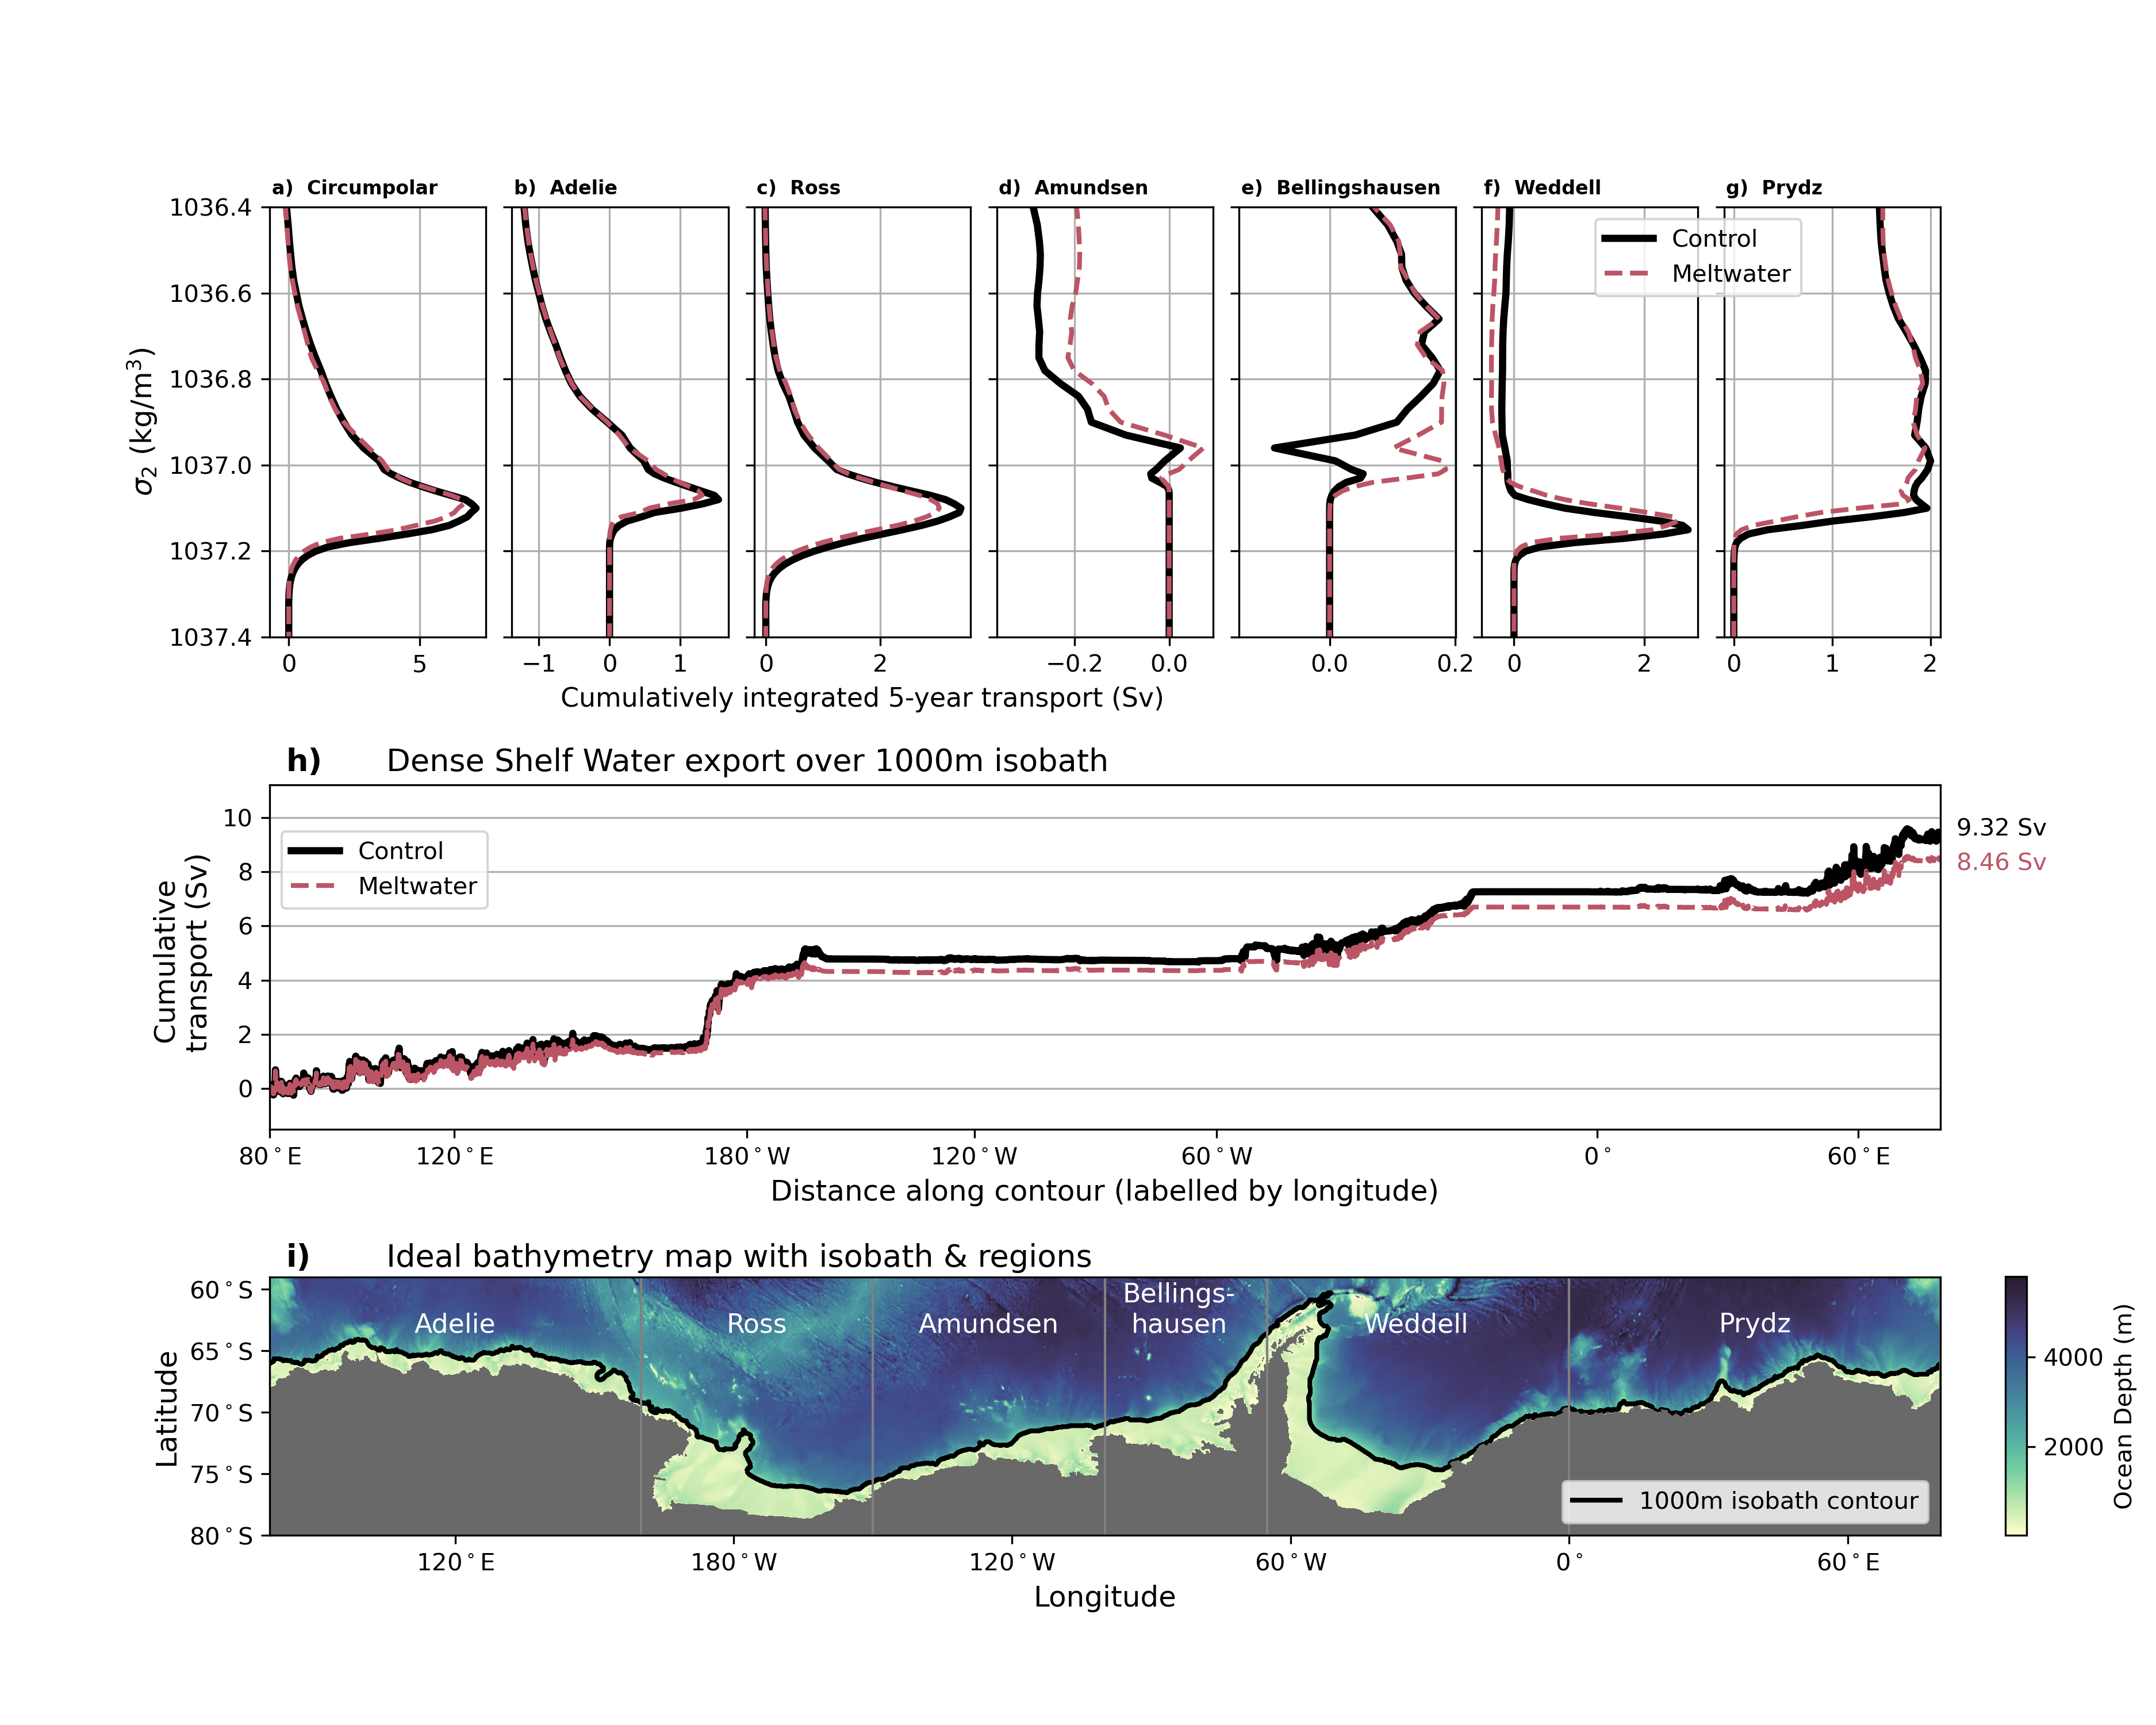

In [30]:
# Plotting config
colors = {'Control': '#000000', 'Melt': '#BB5566'}
linestyles = {'Control': '-', 'Melt': '--'}
linewidths = {'Control': 3, 'Melt': 2}
labels = {'Control': 'Control', 'Melt': 'Meltwater'}


# Define figure and subplots like the reference style
gs = gridspec.GridSpec(3, 7, height_ratios=[1, 0.8, 0.6])
fig = plt.figure(figsize=(12.5, 10), dpi=300)
ax0, ax1, ax2, ax3, ax4, ax4b, ax5, ax6, ax7 = (
    plt.subplot(gs[2, :]), plt.subplot(gs[0, 0]), plt.subplot(gs[0, 1]), plt.subplot(gs[0, 2]),
    plt.subplot(gs[0, 3]), plt.subplot(gs[0, 4]), plt.subplot(gs[0, 5]), plt.subplot(gs[0, 6]),
    plt.subplot(gs[1, :])
)

# Plot bathymetry in ax0
h_plot = deptho.plot(ax=ax0, cmap=cm.cm.deep, add_colorbar=False)
cax = plt.axes([0.93, 0.11, 0.01, 0.15])
plt.colorbar(h_plot, cax=cax, label='Ocean Depth (m)')

ax0.contour(xh, yh, np.abs(mask_x_transport.values) + np.abs(mask_y_transport.values), colors='k')
ax0.contourf(deptho.xh, land_mask_lat, land_mask_masked, colors='dimgrey', zorder=2)

# Optional: Add vlines and region labels
ax0.vlines([-280, -200, -150, -100, -65, 0, 80], -82, -58, color='grey', linewidth=1)

region_labels = ['Adelie', 'Ross', 'Amundsen', 'Bellings-\nhausen', 'Weddell', 'Prydz']
region_lons = [-240, -175, -125, -84, -33, 40]
for x, name in zip(region_lons, region_labels):
    ax0.text(x, -64, name, ha='center', va='bottom', fontsize=11, color='w')

# Legend, labels, title
ax0.plot([0, 1], [0, 1], color='k', linewidth=2, label='1000m isobath contour')  # fake for legend
ax0.legend(loc='lower right')
ax0.set_ylabel('Latitude', fontsize=12)
ax0.set_xlabel('Longitude', fontsize=12)
ax0.set_ylim(min(yh.values), max(yh.values))
ax0.set_xticks([-240, -180, -120, -60, 0, 60])
ax0.set_xticklabels(('120$^\circ$E', '180$^\circ$W', '120$^\circ$W', '60$^\circ$W', '0$^\circ$', '60$^\circ$E'))
ax0.set_yticks([-80, -75, -70, -65, -60])
ax0.set_yticklabels(('80$^\circ$S', '75$^\circ$S', '70$^\circ$S', '65$^\circ$S', '60$^\circ$S'))
ax0.text(0.01, 1.04, 'i)', fontsize=13, fontweight='bold', transform=ax0.transAxes)
ax0.text(0.07, 1.04, 'Ideal bathymetry map with isobath & regions', fontsize=13, transform=ax0.transAxes)

# Plot sector-wise transport profiles
axes = [ax1, ax2, ax3, ax4, ax4b, ax5, ax6]
sectors = [slice(0, 6002), Adelie, Ross, Am, Be, Weddell, Prydz]
sector_names = ['Circumpolar', 'Adelie', 'Ross', 'Amundsen', 'Bellingshausen', 'Weddell', 'Prydz']
letter_labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)']

for n, (ax, sector, name, letter) in enumerate(zip(axes, sectors, sector_names, letter_labels)):
    print(n)
    for key, array in zip(['Control', 'Melt'], [control_array, melt_array]):
        b = (array).sel(contour_index=sector).sum('contour_index') #changed (array / 1e6) to (array)
        transport_profile = (b.sum('rho2_l') - b.cumsum('rho2_l'))
        transport_profile.plot(ax=ax, y='rho2_l',
                               label=labels[key], color=colors[key],
                               linestyle=linestyles[key], linewidth=linewidths[key])
        print(sector_names[n], (b.sum('rho2_l') -b.cumsum('rho2_l')).idxmax('rho2_l').values)

    ax.set_ylim(1037.4, 1036.4)
    ax.grid()
    ax.set_title('')
    ax.text(0.01, 1.03, f'{letter}  {name}', transform=ax.transAxes, fontsize=8, fontweight='bold')
    if n == 0:
        ax.set_ylabel('$\sigma_2$ (kg/m$^3$)', fontsize=12)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    if n == 2:
        ax.set_xlabel('Cumulatively integrated 5-year transport (Sv)', fontsize=11)
    else:
        ax.set_xlabel('')
    if n == 6:
        ax.legend(loc='upper left', bbox_to_anchor=(-0.65, 1), fontsize=10)


### Tweak these slices!!

# Cumulative transport in ax7
slices = {
    'Ade': slice(1037.08,1037.4),
    'Ros': slice(1037.1,1037.4),
    'AmBe': slice(1037,1037.4),
    'We': slice(1037.15,1037.4),
    'Pr': slice(1037.1,1037.4),
}

for key, array in zip(['Control', 'Melt'], [control_array, melt_array]):
    offset = 0 if key == 'Control' else -0.4
    array_copy = xr.zeros_like(array.isel(rho2_l=0))

    for j in range(len(array_copy)):
        if j <= 1270:
            array_copy[j] = array.sel(rho2_l=slices['Ade']).sum('rho2_l').values[j] #/ 1e6
        elif j <= 2149:
            array_copy[j] = array.sel(rho2_l=slices['Ros']).sum('rho2_l').values[j] #/ 1e6
        elif j <= 3338:
            array_copy[j] = array.sel(rho2_l=slices['AmBe']).sum('rho2_l').values[j] #/ 1e6
        elif j <= 4798:
            array_copy[j] = array.sel(rho2_l=slices['We']).sum('rho2_l').values[j] #/ 1e6
        else:
            array_copy[j] = array.sel(rho2_l=slices['Pr']).sum('rho2_l').values[j] #/ 1e6

    cumsum = array_copy.cumsum('contour_index')
    ax7.plot(distance_along_contour, cumsum, label=labels[key],
             color=colors[key], linestyle=linestyles[key], linewidth=linewidths[key])
    ax7.text(distance_along_contour[-1] + 0.2, offset + cumsum[-1],
             f"{cumsum[-1].values:.2f} Sv", color=colors[key], fontsize=10)

# Final ax7 format
ax7.set_ylabel('Cumulative \n transport (Sv)', fontsize=12)
ax7.set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
ax7.set_xticklabels(('80$^\circ$E', '120$^\circ$E', '180$^\circ$W', '120$^\circ$W', '60$^\circ$W', '0$^\circ$', '60$^\circ$E'))
ax7.set_xlim(0, distance_along_contour[-1])
ax7.set_ylim(-1.5, 11.2)
ax7.grid(axis='y')
ax7.set_xlabel('Distance along contour (labelled by longitude)', fontsize=12)
ax7.legend(loc='upper left', bbox_to_anchor=(0, 0.9), fontsize=10)
ax7.text(0.01, 1.04, 'h)', fontsize=13, fontweight='bold', transform=ax7.transAxes)
ax7.text(0.07, 1.04, 'Dense Shelf Water export over 1000m isobath', fontsize=13, transform=ax7.transAxes)

# Adjust spacing
fig.subplots_adjust(hspace=0.43, wspace=0.12)

from IPython.display import display, Image

fig.savefig("my_plot.png", dpi=300)
plt.close(fig)

display(Image(filename="my_plot.png", width=1200))  # Display width in pixels


Note: I've defined the range of DSW export as from the transport peak onwards, as per Claire's notebook. 

Optional saving of just the plotted data below:

In [34]:
import xarray as xr
import numpy as np

# Save transport profiles (per region and experiment)
for sector, name in zip(sectors, sector_names):
    for key, array in zip(['Control', 'Melt'], [control_array, melt_array]):
        b = array.sel(contour_index=sector).sum('contour_index')
        transport_profile = b.sum('rho2_l') - b.cumsum('rho2_l')

        ds = xr.Dataset({
            f'{key}_transport_profile': transport_profile
        })
        ds[f'{key}_transport_profile'].attrs['units'] = 'Sv'
        ds.to_netcdf(f"{name}_{key}_transport_profile.nc")

print("Saved transport profiles for all regions.")

# Save cumulative transport along contour (per experiment)
for key, array in zip(['Control', 'Melt'], [control_array, melt_array]):
    array_copy = xr.zeros_like(array.isel(rho2_l=0))

    for j in range(len(array_copy)):
        if j <= 1270:
            array_copy[j] = array.sel(rho2_l=slices['Ade']).sum('rho2_l').values[j]
        elif j <= 2149:
            array_copy[j] = array.sel(rho2_l=slices['Ros']).sum('rho2_l').values[j]
        elif j <= 3338:
            array_copy[j] = array.sel(rho2_l=slices['AmBe']).sum('rho2_l').values[j]
        elif j <= 4798:
            array_copy[j] = array.sel(rho2_l=slices['We']).sum('rho2_l').values[j]
        else:
            array_copy[j] = array.sel(rho2_l=slices['Pr']).sum('rho2_l').values[j]

    cumsum = array_copy.cumsum('contour_index')

    ds_cum = xr.Dataset({
        f'{key}_cumulative_transport': cumsum,
        'distance_along_contour': (('contour_index',), distance_along_contour.values)
    })
    ds_cum[f'{key}_cumulative_transport'].attrs['units'] = 'Sv'
    ds_cum['distance_along_contour'].attrs['units'] = 'km'  # or other unit

    ds_cum.to_netcdf('/g/data/x77/kc5856/sofia-cross_slope_transport/plots/' + f"{key}_pan01_cumulative_transport.nc")

print("Saved cumulative transport files.")


Saved transport profiles for all regions.
Saved cumulative transport files.
